
## Testing the effect of sampling on computing the kinetic energy of the projectile

We write each initial state $|\Psi_I\rangle = |\psi\rangle\otimes|\psi_\mathrm{proj}\rangle$ where


$$

|\psi_\mathrm{\mathrm{proj}}\rangle = \sum_\mathbf{k} \sqrt{\frac{1}{(2\pi)^{3/2}\sigma_k^3}}e^{-|\mathbf{k}-\mathbf{k}_{\mathrm{proj}}|^2/(4\sigma_k^2)}|\mathbf{k}\rangle

$$

such that 
$$

\langle \mathbf{r} |\psi_\mathrm{\mathrm{proj}}\rangle = \left(\frac{1}{(2\pi)\sigma_k L}\right)^{3/2}e^{i\mathbf{k}\cdot\mathbf{r}}e^{-|\mathbf{k}-\mathbf{k}_{\mathrm{proj}}|^2/(4\sigma_k^2)}

$$

then we want to estimate the number of samples to compute

\begin{align*}

    \langle \hat{T}_\mathrm{\mathrm{proj}}\rangle &= 1/Z \sum_{I} \langle \Psi_I| e^{-\beta(E_I-\mu N)} \hat{T}_\mathrm{\mathrm{proj}} |\Psi_I\rangle \\
        &= 1/Z \sum_I e^{-\beta(E_I-\mu N)} \sum_k \frac{k^2}{2 m_\mathrm{proj}} e^{-|\mathbf{k}-\mathbf{k}_{\mathrm{proj}}|^2/(4\sigma_k^2)}

\end{align*}
In practice because $k_\mathrm{proj}$ is usually very large (outside of the PW grid defined by the DFT $E_{\mathrm{cut}}$) we need to shift the grid by $k_\mathrm{proj}$ and evaluate


$$
        T = 1/Z \sum_I e^{-\beta(E_I-\mu N)} \sum_{k'} \frac{(k'+k_\mathrm{proj})^2}{2} e^{-|k'|^2/(4\sigma_k^2)}
$$
Let's look at the kinetic energy of a wavepacket in 1D. The kinetic energy of a guassian is just it's second moment, i.e.

$$

\langle \hat{T}_{\mathrm{proj}} \rangle = \frac{1}{2 m_{\mathrm{proj}}}\left(k_{\mathrm{mean}}^2 + \sigma^2_k\right)

$$

so $\sigma_k$ controls how well resolved the initial momentum is but there is a tradeoff with $\sigma_r$. 
# 3D

$$

|\psi\rangle = \sum_\mathbf{k} \frac{1}{(2\pi)^{3/4}{\sigma^{3/2}}} e^{\frac{1}{4}(\mathbf{k}-\mathbf{k}_{\mathrm{proj}})/\sigma^2} |\mathbf{k}\rangle

$$

Check normalization quadrature error

$$

\langle \psi | \psi \rangle = \sum_k \Delta_k^3 f(\mathbf{k}) \approx \int d \mathbf{k} f(\mathbf{k}) 

$$

where 

$$

f(\mathbf{k}-\mathbf{k}_\mathrm{proj}) = \frac{1}{(2\pi)^{3/2}{\sigma^{3}}} e^{\frac{1}{2}(\mathbf{k}-\mathbf{k}_{\mathrm{proj}})/\sigma^2}

$$

is our multivariate Guassian distribution.

And kinetic energy should follow from second moment of the PDF 

$$

\mathrm{KE} = \frac{1}{2 m_\mathrm{proj}} \int d\mathrm{k} \mathbf{k}^2 f(\mathbf{k}-\mathbf{k}_\mathrm{proj}) = \frac{1}{2 m_\mathrm{proj}}\left(\mathbf{k}_{\mathrm{proj}}^2 + 3\sigma_k^2\right)


$$

In [1]:
from mec_sandia.ueg import UEG
import math
from ase.units import Hartree
import numpy as np
from mec_sandia.vasp_utils import read_vasp

ase_cell = read_vasp(f"../vasp_data/D_POSCAR")
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr
volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_atoms = len(ase_cell.get_atomic_numbers())
# There is 1 hydrogen atom in the cell. Is this just a proton?
num_elec = num_atoms 
from mec_sandia.vasp_utils import compute_wigner_seitz_radius
# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} a0".format(rs))
print("eta = {} ".format(num_elec))
L_bohr = volume_bohr**(1.0/3.0)
print("L = {} a0".format(L_bohr))

ecut_ev = 2000
ecut_ha = (ecut_ev/Hartree)
factor = (2*np.pi/L_bohr)
ecut_tilde = ecut_ha / (factor**2)
ueg = UEG.build(num_elec, rs, ecut_tilde)
gmax = ueg.gvecs[-1]
nmax = math.floor((2*ecut_tilde)**0.5)
num_pw_1d = (2*nmax - 1)
num_pw = num_pw_1d**3 
print("Npw_x = {}, Npw = {}, Npw_spherical = {}".format(num_pw_1d, num_pw, len(ueg.eigenvalues)))
print("np = {}".format(math.ceil(np.log2(num_pw**(1/3.)))))

Volume = 577.1514824733873 A^3
rs = 0.8132066816006787 a0
eta = 1729 
L = 15.733625397678654 a0
Npw_x = 59, Npw = 205379, Npw_spherical = 117161
np = 6


In [2]:

# Look at error in "projectile kinetic energy"
v_proj = 4.0 # atomic units just taken from carbon
mass_proj = 1836
ke = 0.5 * mass_proj * v_proj**2.0 # classical ke
kproj = np.array([mass_proj*v_proj, 0, 0])

kproj_x = mass_proj * v_proj
import matplotlib.pyplot as plt
factor = (2*np.pi/L_bohr)
sigma_k = 1.0
L_bohr = 15.307
for nmax in np.arange(10, 200, 40):
    ns = np.arange(-nmax, nmax)
    ks = factor * ns
    prefactor = np.pi**0.5/(np.sqrt(2)*L_bohr*sigma_k*mass_proj)
    sum_k = prefactor * np.sum((ks+kproj_x)**2.0*np.exp(-(ks)**2.0/(2*sigma_k**2.0)))
    print(nmax, sigma_k, 0.5*kproj_x**2/mass_proj, sum_k, sigma_k**2.0/(2*mass_proj))
nmax = 20
ns = np.arange(-nmax, nmax)
ks = factor * ns
print(factor)
prefactor = 2*np.pi**0.5/(np.sqrt(2)*L_bohr*sigma_k)
print(prefactor, L_bohr, sigma_k)
print(prefactor * np.sum(np.exp(-(ks**2.0)/(2*sigma_k**2.0))),  np.sum(np.exp(-(ks**2.0)/(2*sigma_k**2.0))))

10 1.0 14688.0 15096.176653004892 0.0002723311546840959
50 1.0 14688.0 15097.373366816517 0.0002723311546840959
90 1.0 14688.0 15097.373366816513 0.0002723311546840959
130 1.0 14688.0 15097.373366816513 0.0002723311546840959
170 1.0 14688.0 15097.373366816513 0.0002723311546840959
0.39934758508402074
0.1637569918750245 15.307 1.0
1.0278712613626848 6.276808395131806


In [5]:

probs = []
for ni in ueg.gvecs:
    k = (2*np.pi/L_bohr) * ni #np.array([ni, nj, nk])
    ksq = np.dot(k, k)
    probs.append(np.exp(-ksq/(2*sigma_k**2.0)))
norm = sum(probs)
probs /= norm
results = []
errs = []
nsamps = [100, 1000, 10000, 100000]
for nsamp in nsamps:
    ks_rand = (2*np.pi/L_bohr)*ueg.gvecs[np.random.choice(np.arange(len(ueg.gvecs)), size=nsamp, p=probs)]
    result = norm*prefactor*(ks_rand)**2.0
    results.append(np.mean(result)/(2*mass_proj))
    errs.append(np.std(result, ddof=1)/(2*mass_proj*nsamp**0.5))


<ErrorbarContainer object of 3 artists>

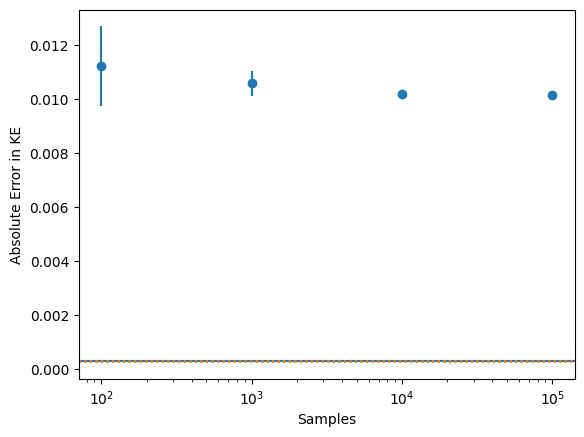

In [6]:

# variance grows by ~ factor of 0.0035
# Look at sigma +/- growth factor on this scale 
sigma_plus = sigma_k + 0.0035**0.5
sigma_minu = sigma_k - 0.0035**0.5

import matplotlib.pyplot as plt 
plt.xscale("log")
plt.xlabel("Samples")
plt.ylabel("Absolute Error in KE")
plt.axhline(sigma_k**2.0/(2*mass_proj))
plt.axhline(sigma_plus**2.0/(2*mass_proj), color="C1", linestyle=":")
plt.axhline(sigma_minu**2.0/(2*mass_proj), color="C1", linestyle=":")
plt.errorbar(nsamps, results, yerr=errs, fmt="o")


# Gaussian State Preparation

**--Equation Dump--**

Ref [1] outlines how to approximately preparare a 1D Gaussian state

$$

|G(\sigma,\mu)\rangle = \frac{1}{\mathcal{N}} \int dx e^{-\left(\frac{x-\mu}{\sigma}\right)^2} |x\rangle; \quad \mathcal{N}^2 = \sigma \sqrt{2\pi}

$$

which is approximated by a discreted 1DGS (Kitaev-Webb (KW))

$$

|G_{\mathrm{KW}}(\sigma,\mu)\rangle = \sum_{i\in\mathbb{Z}} G_{\mathrm{KW}}(\sigma,\mu;i)|i \rangle

$$

where

$$
G_{\mathrm{KW}}(\sigma,\mu;i) = \frac{1}{f_{\mathrm{KW}(\sigma,\mu)}} e^{\frac{(i-\mu)^2}{4\sigma^2}}, \quad f_{\mathrm{KW}}(\sigma,\mu) = \sum_{i\in\mathbb{Z}} e^{\frac{(i-\mu)^2}{4\sigma^2}}.

$$

In practice, we further approximate 

$$
G_{\mathrm{KW}}(\sigma,\mu,i) \approx \sum_j^{2^m-1}G_{\mathrm{KW}}(\sigma,\mu,i+j2^m).
$$

There are then two approximations: 1) the representation of a Gaussian state defined for continuous values of the position, and 2) the description of this discretized Gaussian using a fixed prescision real numbers, i.e. every real number is associated with a $p$-bit integer. The question is then how to generate this state, and how much do these approximations matter in practice.

From [1], they say the (integer) largest value for a real number is $2^m$, so they use $m$ to be the radix point position (the number of bits to the left of the decimal point).  


In our case we just want to prepare the state

$$

\psi(k) = C e^{-(k-\mu)^2/4\sigma^2}

$$

which can be approximated as


$$

|\psi \rangle = \tilde{C} \sum_n \delta e^{-n^2/(4\tilde{\sigma})^2} |\delta n\rangle

$$

where $k$ is a continuous variable in principle. In practice $k$ lives on a discrete grid given by $[-2\pi n/L, 2\pi/L)$, where $L$ is the size of the supercell, and the range of $n$ is usually fixed by the planewave cutoff, $\frac{1}{2}(k_{\max}-k_{\mathrm{mean}})^2 \le E_{\mathrm{cut}}$, which for us is typically $n \approx 61$, $\delta = 2\pi/L$

[1] suggests two algorithms to generate a Gaussian. The first is a recursive algorithm where the amplitudes $\approx e^{k^2/\sigma^2}$  are prepared on the quantum computer via

$$

|\xi(\sigma, \mu, m)\rangle = |\xi(\sigma/2,\mu/2,m-1)\rangle\otimes|0\rangle + |\xi(\sigma,(\mu-1)/2,m-1\rangle)\otimes|1\rangle, \quad \theta = \arccos\sqrt{\frac{f_{\mathrm{KW}}(\sigma, \mu/2)}{f_{\mathrm{KW}}(\sigma, \mu)}}.

$$

This is problematic because it involves computing $\arccos$ and $f_{\mathrm{KW}}$ on the quantum computer.

The second approach is to use an idea similar to alias sampling described in the linear-T complexity paper. At a high level we can classically compute the amplitudes, load these into a register and probabilistically sample from this distribution such that some uniformly prepared initial state ends up in a correctly weighted state.


[1] https://arxiv.org/pdf/2110.05708.pdf



* Test these classically.
* Cost alias sampling approach (this should be in the PRL).
* Check error given planewave cutoffs we expect and sigma.